In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers,Input,optimizers

In [24]:
apple = pd.read_csv("AAPL.csv")
amazon = pd.read_csv("AMZN.csv")
google = pd.read_csv("GOOG.csv")
google_l = pd.read_csv("GOOGL.csv")
microsoft = pd.read_csv("MSFT.csv")
tesla = pd.read_csv("TSLA.csv")


def paint(data):
    data = data.iloc[::-1]
    data = data.reset_index(drop=True)
    #data['Label'] = np.where(data['adj close'].shift(-1) > data['adj close'], 1, 0)
    #data['Label'] = (data['close'] > data['open']).astype(int)
    return data


apple = paint(apple)
amazon = paint(amazon)
google = paint(google)
google_l = paint(google_l)
microsoft = paint(microsoft)
tesla = paint(tesla)

tweets = pd.read_csv("D:\johnny的文件夹\FDU 课程\大二下\大数据商务分析\Final project\data\Tweet\Tweet.csv")
company_tweets = pd.read_csv(
    "D:\johnny的文件夹\FDU 课程\大二下\大数据商务分析\Final project\data\Tweet\Company_Tweet.csv")
tweets.drop('writer', axis=1, inplace=True)
df_tweets = pd.merge(tweets, company_tweets, on='tweet_id', how='left')
df_tweets['post_date'] = pd.to_datetime(df_tweets['post_date'], unit='s')
df_tweets['post_date'] = df_tweets['post_date'].dt.strftime('%Y-%m-%d')
df_tweets.drop('tweet_id', axis=1, inplace=True)
df_tweets['tweet_score'] = 1 * df_tweets['comment_num'] + 1 * df_tweets['retweet_num'] + 1.2 * df_tweets['like_num']
df_tweets = df_tweets[df_tweets['tweet_score'] >= 50].reset_index()
df_tweets.drop('index', axis=1, inplace=True)
df_tweets.drop('comment_num', axis=1, inplace=True)
df_tweets.drop('retweet_num', axis=1, inplace=True)
df_tweets.drop('like_num', axis=1, inplace=True)

df_tweets.rename(columns={'post_date': 'date'}, inplace=True)
df_tweets['date'] = pd.to_datetime(df_tweets['date'])

def explore(df, company):
    df1 = df[df['ticker_symbol'] == company]
    score = df1.groupby('date')['tweet_score'].sum()
    df1 = pd.concat([score], axis=1)
    df1 = df1.reset_index()
    return df1


apple_tweets = explore(df_tweets, 'AAPL')
amazon_tweets = explore(df_tweets, 'AMZN')
google_tweets = explore(df_tweets, 'GOOG')
googlel_tweets = explore(df_tweets, 'GOOGL')
microsoft_tweets = explore(df_tweets, 'MSFT')
tesla_tweets = explore(df_tweets, 'TSLA')

def make_stock(stock, tweet):
    stock['date'] = pd.to_datetime(stock['date'])
    tweet['date'] = pd.to_datetime(tweet['date'])

    start_date = '2015-01-01'
    end_date = '2019-12-31'
    stock = stock.loc[(stock['date'] >= start_date) & (stock['date'] <= end_date)]
    result = pd.merge(stock, tweet, on='date', how='left')
    return result

apple = make_stock(apple, apple_tweets).dropna()
amazon = make_stock(amazon, amazon_tweets).dropna()
google = make_stock(google, google_tweets).dropna()
googlel = make_stock(google_l, googlel_tweets).dropna()
microsoft = make_stock(microsoft, microsoft_tweets).dropna()
tesla = make_stock(tesla, tesla_tweets).dropna()

In [25]:
apple

,date,open,high,low,close,adj close,volume,tweet_score
0,2015-01-02,111.389999,111.440002,107.349998,109.330002,100.216454,53204600,1687.2
1,2015-01-05,108.290001,108.650002,105.410004,106.250000,97.393181,64285500,280.0
4,2015-01-08,109.230003,112.150002,108.699997,111.889999,102.563072,59364500,248.2
5,2015-01-09,112.669998,113.250000,110.209999,112.010002,102.673050,53699500,93.8
6,2015-01-12,112.599998,112.629997,108.800003,109.250000,100.143120,49650800,76.6
...,...,...,...,...,...,...,...,...
1253,2019-12-24,284.690002,284.890015,282.920013,284.269989,283.596924,12119700,572.8
1254,2019-12-26,284.820007,289.980011,284.700012,289.910004,289.223602,23280300,853.4
1255,2019-12-27,291.119995,293.970001,288.119995,289.799988,289.113831,36566500,202.6
1256,2019-12-30,289.459991,292.690002,285.220001,291.519989,290.829773,36028600,1468.4


In [52]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

df=pd.DataFrame(apple,columns=['date','open','close','tweet_score'])
data = df[['open','close','tweet_score']].values
# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data)

# 创建数据集
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, :2])  
    return np.array(X), np.array(y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


[[0.09560711 0.09340419 0.09712747]
 [0.08000806 0.0782549  0.01364483]
 [0.08473811 0.10599579 0.01175828]
 ...
 [1.         0.98106337 0.00905305]
 [0.99164694 0.98952336 0.08414708]
 [0.99401196 1.         0.05918297]]


In [54]:
# 创建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 3)))  # 输入形状为(time_step, 2)
model.add(LSTM(units=50))
model.add(Dense(2))  # 输出2个值，即预测的open and closing价格

model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反归一化
train_predict_full = np.concatenate((train_predict, np.zeros((train_predict.shape[0], 1))), axis=1)
test_predict_full = np.concatenate((test_predict, np.zeros((test_predict.shape[0], 1))), axis=1)
train_predict = scaler.inverse_transform(train_predict_full)[:, :2]
test_predict = scaler.inverse_transform(test_predict_full)[:, :2]


Epoch 1/40


C:\Users\johnn\PycharmProjects\Deep Learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0432 - val_loss: 0.0178
Epoch 2/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 3/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 4/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 5/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 9.2207e-04 - val_loss: 0.0021
Epoch 6/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 8.9275e-04 - val_loss: 0.0030
Epoch 7/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 8.2417e-04 - val_loss: 0.0026
Epoch 8/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 7.2916e-04 - val_loss: 0.0020
Epoch 9/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 7.1160e-04 - val_loss: 0.0036
Epoch 10/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 7.2730e-04 - val_loss: 0.0018
Epoch 11/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 7.5860e-04 - val_loss: 0.0013
Epoch 12/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms

In [28]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)
print(train_mse, test_mse)
# accuracy, mse
# 相对于原始数据的涨跌

21730.138159288574 44844.9225948606


In [29]:
test_predict

array([[172.01072099, 170.80622048],
       [172.51837204, 171.27976417],
       [172.65533253, 171.44088196],
       [172.37252764, 171.24291266],
       [171.50865496, 170.52098181],
       [171.85092882, 170.8172117 ],
       [173.26964989, 172.02545884],
       [175.13480585, 173.64737355],
       [177.32581227, 175.61823847],
       [179.79399117, 177.91358085],
       [182.18596377, 180.20863845],
       [183.91433101, 181.94944502],
       [184.94198178, 183.10318441],
       [187.14249399, 185.28436709],
       [188.96029865, 187.07253772],
       [189.66859607, 187.93694855],
       [189.23540413, 187.75525401],
       [188.11320473, 186.89861703],
       [186.83532939, 185.79912485],
       [186.01692463, 185.00447862],
       [185.90671068, 184.76310185],
       [186.5015071 , 185.15004874],
       [187.90365076, 186.30120695],
       [189.55976209, 187.73985781],
       [191.18153409, 189.20803472],
       [193.04517979, 190.97163566],
       [194.79042056, 192.6483126 ],
 

In [30]:
train_predict

array([[122.52657341, 122.6171939 ],
       [122.23417389, 122.30245343],
       [122.35217607, 122.35623409],
       ...,
       [170.87410594, 169.70947308],
       [171.15956416, 169.99342721],
       [171.45734142, 170.29011154]])

In [31]:
open_predict = np.concatenate([train_predict[:,0], test_predict[:,0]], axis=0)
close_predict = np.concatenate([train_predict[:,1], test_predict[:,1]], axis=0)


In [32]:
open_predict.shape

(1015,)

Text(0.5, 1.0, 'Stock Price Prediction')

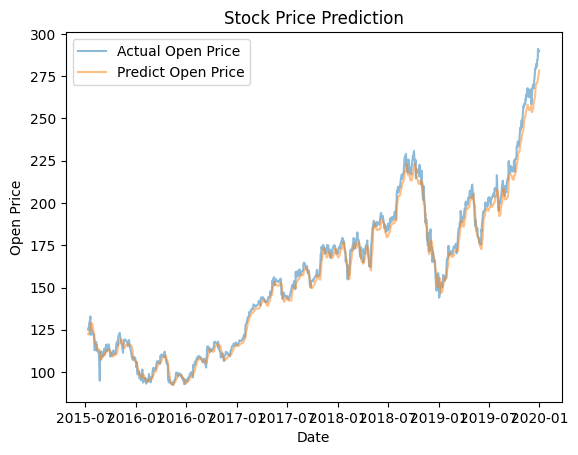

In [33]:
import matplotlib.pyplot as plt
plt.plot(df['date'][time_step:], df['open'][time_step:], label='Actual Open Price', alpha=0.5)
plt.plot(df['date'][time_step:], open_predict, label='Predict Open Price', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Stock Price Prediction')

Text(0.5, 1.0, 'Stock Price Prediction')

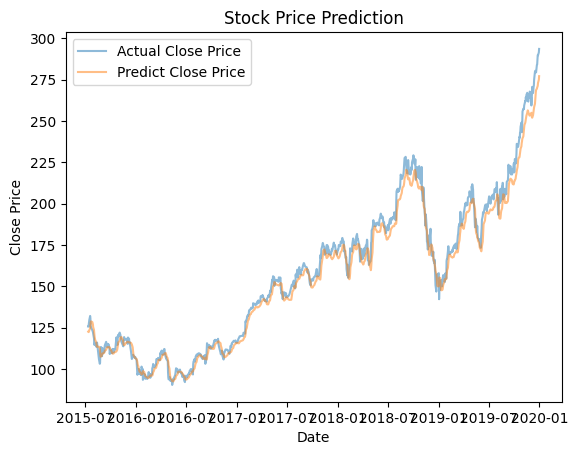

In [34]:
plt.plot(df['date'][time_step:], df['close'][time_step:], label='Actual Close Price', alpha=0.5)
plt.plot(df['date'][time_step:], close_predict, label='Predict Close Price', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction')

In [35]:
prediction = pd.DataFrame({'pre_open':open_predict, 'pre_close':close_predict})
prediction

,pre_open,pre_close
0,122.526573,122.617194
1,122.234174,122.302453
2,122.352176,122.356234
3,122.797317,122.722132
4,123.665291,123.494365
...,...,...
1010,271.385983,270.325813
1011,272.353418,271.295150
1012,274.211414,273.037507
1013,276.282114,274.982312


In [36]:
apple_df = apple[['date','open','close']].tail(1015)
apple_df.reset_index(inplace=True)

In [37]:
apple_df = apple_df.head(1010)
apple_df.drop('index', axis=1, inplace=True)

In [38]:
prediction = prediction.head(1010)
prediction

,pre_open,pre_close
0,122.526573,122.617194
1,122.234174,122.302453
2,122.352176,122.356234
3,122.797317,122.722132
4,123.665291,123.494365
...,...,...
1005,265.082342,262.909632
1006,267.500486,265.396158
1007,269.179133,267.345482
1008,270.256682,268.773942


In [39]:
apple_df

,date,open,close
0,2015-07-13,125.029999,125.660004
1,2015-07-14,126.040001,125.610001
2,2015-07-15,125.720001,126.820000
3,2015-07-16,127.739998,128.509995
4,2015-07-17,129.080002,129.619995
...,...,...,...
1005,2019-12-17,279.570007,280.410004
1006,2019-12-18,279.799988,279.739990
1007,2019-12-19,279.500000,280.019989
1008,2019-12-20,282.230011,279.440002


In [40]:
apple_stock = pd.concat([apple_df, prediction], axis=1)
apple_stock

,date,open,close,pre_open,pre_close
0,2015-07-13,125.029999,125.660004,122.526573,122.617194
1,2015-07-14,126.040001,125.610001,122.234174,122.302453
2,2015-07-15,125.720001,126.820000,122.352176,122.356234
3,2015-07-16,127.739998,128.509995,122.797317,122.722132
4,2015-07-17,129.080002,129.619995,123.665291,123.494365
...,...,...,...,...,...
1005,2019-12-17,279.570007,280.410004,265.082342,262.909632
1006,2019-12-18,279.799988,279.739990,267.500486,265.396158
1007,2019-12-19,279.500000,280.019989,269.179133,267.345482
1008,2019-12-20,282.230011,279.440002,270.256682,268.773942


In [41]:
apple_stock['pre_Label'] = np.where(apple_stock['pre_close'].shift(-1) > apple_stock['pre_close'], 1, 0)
apple_stock['Label'] = np.where(apple_stock['close'].shift(-1) > apple_stock['close'], 1, 0)
apple_stock.dropna(inplace=True)

In [42]:
apple_stock

,date,open,close,pre_open,pre_close,pre_Label,Label
0,2015-07-13,125.029999,125.660004,122.526573,122.617194,0,0
1,2015-07-14,126.040001,125.610001,122.234174,122.302453,1,1
2,2015-07-15,125.720001,126.820000,122.352176,122.356234,1,1
3,2015-07-16,127.739998,128.509995,122.797317,122.722132,1,1
4,2015-07-17,129.080002,129.619995,123.665291,123.494365,1,1
...,...,...,...,...,...,...,...
1005,2019-12-17,279.570007,280.410004,265.082342,262.909632,1,0
1006,2019-12-18,279.799988,279.739990,267.500486,265.396158,1,1
1007,2019-12-19,279.500000,280.019989,269.179133,267.345482,1,0
1008,2019-12-20,282.230011,279.440002,270.256682,268.773942,1,1


In [43]:
TP = ((apple_stock['Label'] == 1) & (apple_stock['pre_Label'] == 1)).sum()
FP = ((apple_stock['Label'] == 0) & (apple_stock['pre_Label'] == 1)).sum()
FN = ((apple_stock['Label'] == 1) & (apple_stock['pre_Label'] == 0)).sum()

# 计算 Precision 和 Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall)
print(precision, recall, f1)

0.5628140703517588 0.6142595978062158 0.5874125874125875


In [44]:
initial_fund = 10000
funds = initial_fund
for index in range(len(apple_stock) - 1):
    if apple_stock.loc[index, 'pre_Label'] == 1:
        funds += (apple_stock.loc[index + 1, 'close'] - apple_stock.loc[index + 1, 'open'])
print(funds)

10120.82024383545


In [61]:
X = []
y = []
for i in range(len(scaled_data)-100-7+1):
    X.append(scaled_data[i:i+100])
    y.append(scaled_data[i+100+7-1, 1])  
X = np.array(X)
y = np.array(y)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(100, 3)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=40, batch_size=32,validation_data=(X_test, y_test))
predictions = []
for i in range(len(X) - split):
    predictions.append(model.predict(np.expand_dims(X[split+i], axis=0))[0, 0])
predictions = scaler.inverse_transform([[0, pred, 0] for pred in predictions])[:, 1]
print(predictions)

Epoch 1/40


C:\Users\johnn\PycharmProjects\Deep Learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0349 - val_loss: 0.0093
Epoch 2/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0026 - val_loss: 0.0049
Epoch 3/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 4/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0021 - val_loss: 0.0065
Epoch 5/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 6/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0019 - val_loss: 0.0050
Epoch 7/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0015 - val_loss: 0.0065
Epoch 8/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0016 - val_loss: 0.0079
Epoch 9/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0015 - val_loss: 0.0056
Epoch 10/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 11/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0014 - val_loss: 0.0061
Epoch 12/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0014 - val_l

In [62]:
predictions = pd.DataFrame(predictions, columns=['pred'])

In [63]:
predictions

,pred
0,170.884922
1,171.149802
2,171.643359
3,171.897866
4,172.277433
...,...
197,242.937884
198,244.300627
199,245.721088
200,246.994810


In [65]:
apple_df = apple[913:]
apple_df.reset_index(inplace=True)
apple_df

,index,date,open,high,low,close,adj close,volume,tweet_score
0,1049,2019-03-06,174.669998,175.490005,173.940002,174.520004,172.265228,20810400,303.0
1,1050,2019-03-07,173.869995,174.440002,172.020004,172.500000,170.271317,24796400,794.4
2,1051,2019-03-08,170.320007,173.070007,169.500000,172.910004,170.676025,23999400,180.2
3,1052,2019-03-11,175.490005,179.119995,175.350006,178.899994,176.588608,32011000,770.2
4,1053,2019-03-12,180.000000,182.669998,179.369995,180.910004,178.572662,32467600,684.4
...,...,...,...,...,...,...,...,...,...
197,1253,2019-12-24,284.690002,284.890015,282.920013,284.269989,283.596924,12119700,572.8
198,1254,2019-12-26,284.820007,289.980011,284.700012,289.910004,289.223602,23280300,853.4
199,1255,2019-12-27,291.119995,293.970001,288.119995,289.799988,289.113831,36566500,202.6
200,1256,2019-12-30,289.459991,292.690002,285.220001,291.519989,290.829773,36028600,1468.4


In [66]:
apple_stock1 = pd.concat([apple_df, predictions], axis=1)
apple_stock1

,index,date,open,high,low,close,adj close,volume,tweet_score,pred
0,1049,2019-03-06,174.669998,175.490005,173.940002,174.520004,172.265228,20810400,303.0,170.884922
1,1050,2019-03-07,173.869995,174.440002,172.020004,172.500000,170.271317,24796400,794.4,171.149802
2,1051,2019-03-08,170.320007,173.070007,169.500000,172.910004,170.676025,23999400,180.2,171.643359
3,1052,2019-03-11,175.490005,179.119995,175.350006,178.899994,176.588608,32011000,770.2,171.897866
4,1053,2019-03-12,180.000000,182.669998,179.369995,180.910004,178.572662,32467600,684.4,172.277433
...,...,...,...,...,...,...,...,...,...,...
197,1253,2019-12-24,284.690002,284.890015,282.920013,284.269989,283.596924,12119700,572.8,242.937884
198,1254,2019-12-26,284.820007,289.980011,284.700012,289.910004,289.223602,23280300,853.4,244.300627
199,1255,2019-12-27,291.119995,293.970001,288.119995,289.799988,289.113831,36566500,202.6,245.721088
200,1256,2019-12-30,289.459991,292.690002,285.220001,291.519989,290.829773,36028600,1468.4,246.994810


In [68]:
apple_stock1['pre_Label'] = np.where(apple_stock1['pred'].shift(-1) > apple_stock1['pred'], 1, 0)
apple_stock1['Label'] = np.where(apple_stock1['close'].shift(-1) > apple_stock1['close'], 1, 0)
TP = ((apple_stock1['Label'] == 1) & (apple_stock1['pre_Label'] == 1)).sum()
FP = ((apple_stock1['Label'] == 0) & (apple_stock1['pre_Label'] == 1)).sum()
FN = ((apple_stock1['Label'] == 1) & (apple_stock1['pre_Label'] == 0)).sum()

# 计算 Precision 和 Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall)
print(precision, recall, f1)

0.5886524822695035 0.7033898305084746 0.6409266409266409
